In [1]:
GRID_PATH =  'import/stellar/grid/bosz_5000'

In [2]:
%matplotlib inline

In [4]:
import os
import sys
import getpass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [5]:
# Allow load project as module
sys.path.insert(0, '../..')

In [6]:
os.environ['PFSSPEC_DATA'] = r'/scratch/ceph/dobos/data/pfsspec'
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

# Load BOSZ grid

In [25]:
from pfsspec.data.arraygrid import ArrayGrid
from pfsspec.stellarmod.modelgrid import ModelGrid
from pfsspec.stellarmod.bosz import Bosz

In [32]:
fn = os.path.join(os.environ['PFSSPEC_DATA'], GRID_PATH, 'spectra.h5')
grid = ModelGrid(Bosz(), ArrayGrid)
grid.preload_arrays = False
grid.load(fn, format='h5')

# Fix wave

In [33]:
def correct_wave_grid(wlim, resolution):
    # BOSZ spectra are written to the disk with 3 decimals which aren't
    # enough to represent wavelength at high resolutions. This code is
    # from the original Kurucz SYNTHE to recalculate the wavelength grid.

    RESOLU = resolution
    WLBEG = wlim[0]  # nm
    WLEND = wlim[1]  # nm
    RATIO = 1. + 1. / RESOLU
    RATIOLG = np.log10(RATIO)
    
    IXWLBEG = int(np.round(np.log10(WLBEG) / RATIOLG))
    WBEGIN = 10 ** (IXWLBEG * RATIOLG)
    if WBEGIN < WLBEG:
        IXWLBEG = IXWLBEG + 1
        WBEGIN = 10 ** (IXWLBEG * RATIOLG)
        
    IXWLEND = int(np.round(np.log10(WLEND) / RATIOLG))
    WLLAST = 10 ** (IXWLEND * RATIOLG)
    if WLLAST >= WLEND:
        IXWLEND = IXWLEND - 1
        WLLAST = 10 ** (IXWLEND * RATIOLG)
    LENGTH = IXWLEND - IXWLBEG + 1
    DWLBEG = WBEGIN * RATIO - WBEGIN
    DWLLAST = WLLAST - WLLAST / RATIO
    
    a = np.linspace(np.log10(WBEGIN), np.log10(WLLAST), LENGTH)
    cwave = 10 ** a
    
    return cwave

In [36]:
cwave = 10 * correct_wave_grid((100, 32000), 300000)
cwave

array([  1000.00213876,   1000.0054721 ,   1000.00880545, ...,
       319997.28934199, 319998.35599962, 319999.42266081])

In [40]:
grid.wave.min(), grid.wave.max(), grid.wave.shape

(2000.1075, 17499.9395, (21691,))

In [42]:
nwave = cwave[::30][(2000 < cwave[::30]) & (cwave[::30] < 17500)]
nwave, nwave.shape

(array([ 2000.10760864,  2000.30762907,  2000.5076695 , ...,
        17496.43889991, 17498.18862837, 17499.93853181]),
 (21691,))

In [43]:
grid.wave

array([ 2000.1075,  2000.3076,  2000.5077, ..., 17496.4395, 17498.1875,
       17499.9395])

In [27]:
spec = grid.get_nearest_model(Fe_H=-0.5, T_eff=7500, log_g=1.5, C_M=0, O_M=0)

In [28]:
mask = (6000 < spec.wave) & (spec.wave < 9000)

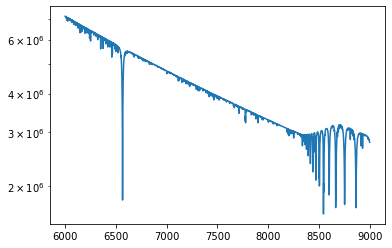

In [29]:
plt.plot(spec.wave[mask], spec.flux[mask])
plt.yscale('log')

In [31]:
spec.wave[1:] / (spec.wave[1:] - spec.wave[:-1])

array([ 9996.53973013,  9997.53973013,  9998.53973015, ...,
        9997.96542857, 10010.40474829,  9988.54994292])

In [46]:
0.5 * (nwave[1:] + nwave[:-1]) / (nwave[1:] - nwave[:-1])

array([10000.01667499, 10000.01667489, 10000.01667491, ...,
       10000.01667491, 10000.01667498, 10000.01667501])

In [47]:
grid.wave = nwave

# Get spectrum with precise wave

In [52]:
spec = grid.get_nearest_model(Fe_H=-0.5, T_eff=7500, log_g=1.5, C_M=0, O_M=0)

In [53]:
mask = (6000 < spec.wave) & (spec.wave < 9000)

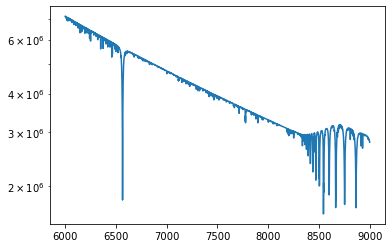

In [49]:
plt.plot(spec.wave[mask], spec.flux[mask])
plt.yscale('log')

# Create the kernel

In [1]:
def get_sigmas(wave_ref=5000, res_input=5000, res_output=3000):
    sigma_input = wave_ref / res_input
    sigma_output = wave_ref / res_output
    sigma_kernel = np.sqrt(sigma_output**2 - sigma_input**2)
    return sigma_input, sigma_output, sigma_kernel    

In [55]:
wave_ref = 5000
res_input = 5000
res_output = 3000
sigma_input = wave_ref / res_input
sigma_output = wave_ref / res_output
sigma_kernel = np.sqrt(sigma_output**2 - sigma_input**2)
sigma_input, sigma_output, sigma_kernel

(1.0, 1.6666666666666667, 1.3333333333333335)

In [72]:
kernel_mask = (wave_ref - 5 < spec.wave) & (spec.wave < wave_ref + 5)
spec.wave[kernel_mask].shape

(20,)

In [91]:
kernel_wave = spec.wave[kernel_mask][:-1]
kernel_wave -= kernel_wave[kernel_wave.size // 2]
kernel_wave.shape, kernel_wave

((19,),
 array([-4.49779514, -3.99824001, -3.49863491, -2.99897985, -2.49927483,
        -1.99951983, -1.49971485, -0.99985989, -0.49995494,  0.        ,
         0.50000494,  1.00005988,  1.50016483,  2.00031979,  2.50052477,
         3.00077978,  3.50108481,  4.00143987,  4.50184497]))

In [92]:
def gauss_kernel(dwave, sigma):
    return 1.0 / np.sqrt(2 * np.pi) / sigma * np.exp(-dwave**2 / (2 * sigma**2))

In [93]:
kernel = gauss_kernel(kernel_wave, sigma_kernel)
kernel /= np.sum(kernel)

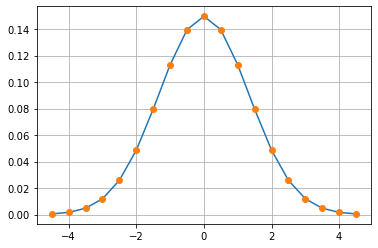

In [94]:
plt.plot(kernel_wave, kernel)
plt.plot(kernel_wave, kernel, 'o')
plt.grid()

In [97]:
nflux = np.convolve(kernel, spec.flux, mode='same')
spec.flux.shape, nflux.shape

((21691,), (21691,))

In [105]:
mask = (8600 < spec.wave) & (spec.wave < 8700)

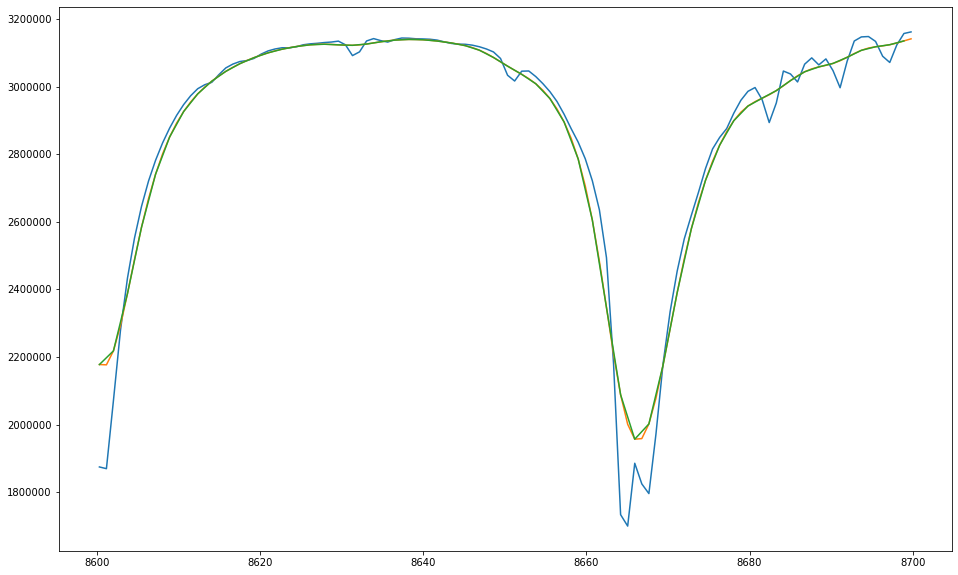

In [108]:
plt.figure(figsize=(16, 10))

plt.plot(spec.wave[mask], spec.flux[mask])
plt.plot(spec.wave[mask], nflux[mask])
plt.plot(spec.wave[mask][::2], nflux[mask][::2])

